### This notebook explores the clusters formed by various unsupervised learning algorithms. The reader is expected to have basic knowledge of how DBSCAN and K-means work.

We will be discussing the partional algorithms which divides the dataset into several clusters. In case of Kmeans where we need to know the number of clusters and in case of DBSCAN we dont. But the catch with DBSCAN is that we have two hyperparameters epsilon and min-samples that we will see below in the notebook. 

Defining the number of clusters before hand requires domain knowledge which can be challenging. Various methods like the elbow chart, silhoute distance method, gap statistics are developed to bridge the shortcommings. 

##### This kernel is heavily based on Robert Kwiatkowski's notebook

In [235]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation

from sklearn.metrics import silhouette_score
import plotly as py
import plotly.graph_objs as go
import scipy.cluster.hierarchy as sch
from itertools import product


In [6]:
data = pd.read_csv('Mall_Customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
print(data.shape)

(200, 5)


In [4]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

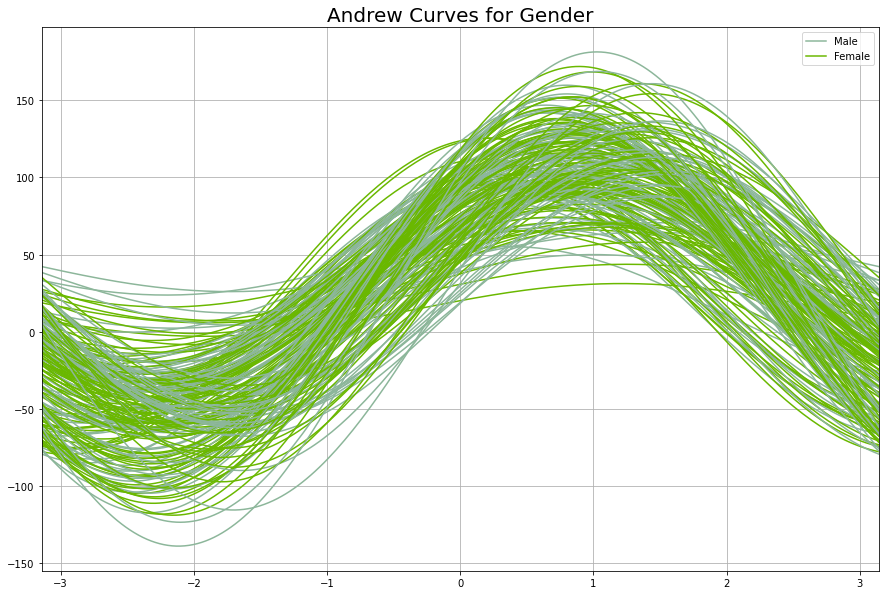

In [218]:
plt.rcParams['figure.figsize'] = (15, 10)


pd.plotting.andrews_curves(data.drop("CustomerID", axis=1), "Gender")
plt.title('Andrew Curves for Gender', fontsize = 20)
plt.show()

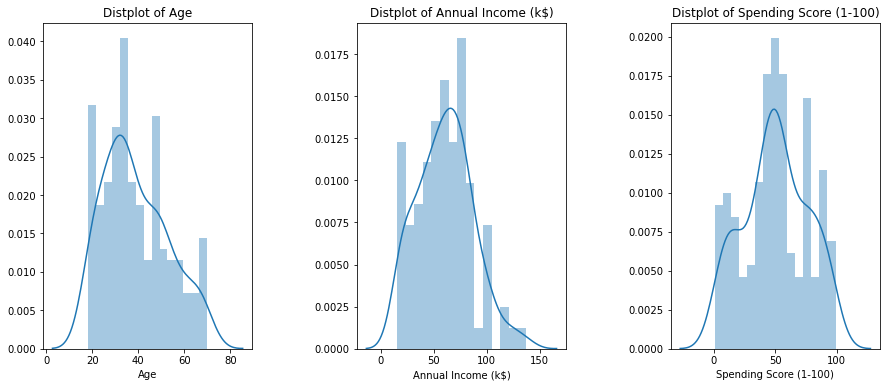

In [9]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.distplot(data[x] , bins = 15)
    plt.title('Distplot of {}'.format(x))
plt.show()

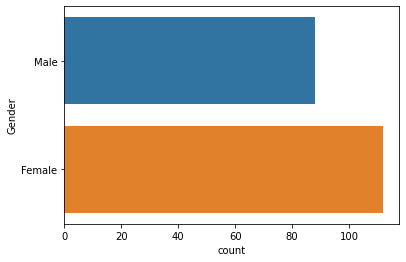

In [10]:
sns.countplot(y = 'Gender' , data = data)

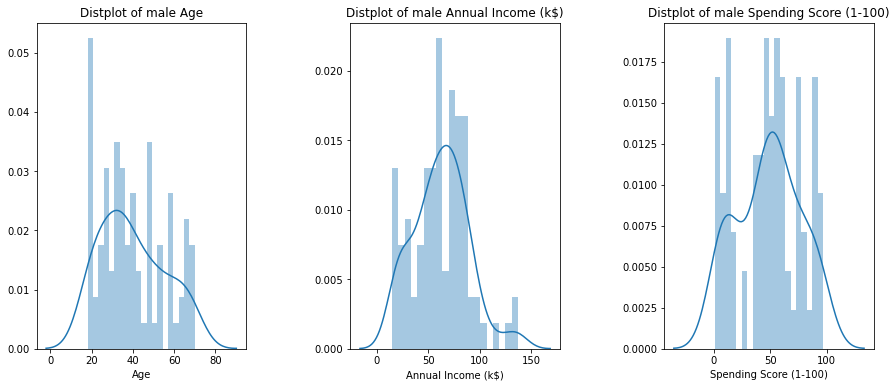

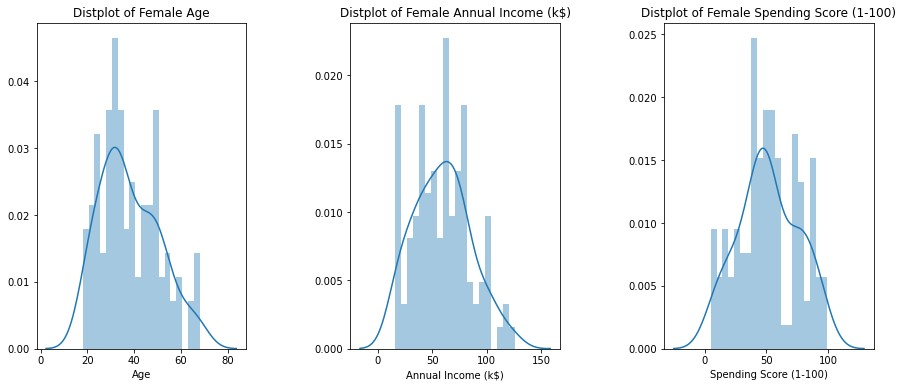

In [13]:
#Subsetting the dataframes for different gender groups
data_male = data[data['Gender'] == 'Male']
data_female = data[data['Gender'] == 'Female']

#Explore the Age , Income and Spending score for Males
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.distplot(data_male[x] , bins = 20)
    plt.title('Distplot of male {}'.format(x))
plt.show()

#Explore the Age, Income and Spending score of Females
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.distplot(data_female[x] , bins = 20)
    plt.title('Distplot of Female {}'.format(x))
plt.show()




In [18]:
#Investigate different age groups for males and females
males_age = data[data['Gender']=='Male']['Age'] # subset with males age
females_age = data[data['Gender']=='Female']['Age'] # subset with females age

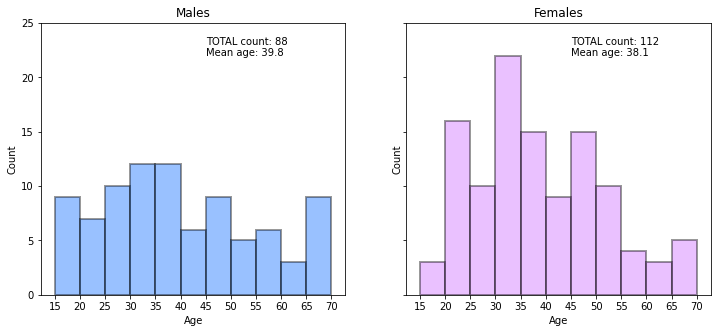

In [24]:
age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_ylim(top=25)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

The average age of male customers is lightly higher than female ones (39.8 versus 38.1). Distribution of male age is more uniform than females, where we can observe that the biggest age group is 30-35 years old

Text(50, 13, 'Std. deviation score: 24.1')

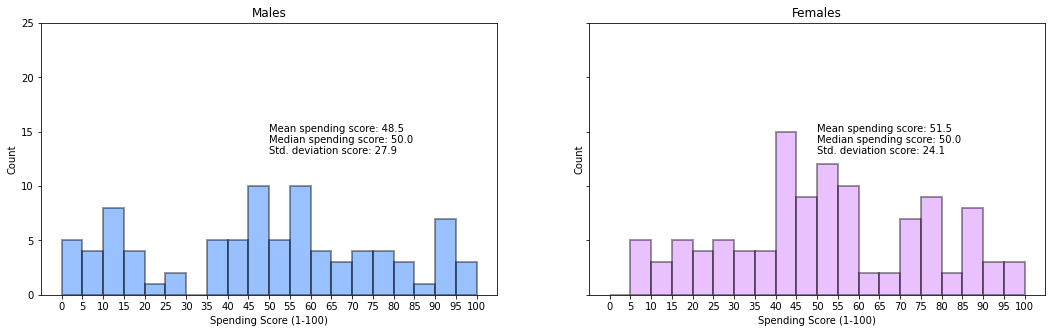

In [29]:
#Who spends more? 
male_spendings = data[data['Gender']=='Male']['Spending Score (1-100)'] # subset with males spending power
female_spendings = data[data['Gender']=='Female']['Spending Score (1-100)'] # subset with spending power

spending_bin = range(0,105,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5), sharey=True)
sns.distplot(male_spendings, bins=spending_bin, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bin)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(male_spendings.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(male_spendings.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(male_spendings.std()))

# females histogram
sns.distplot(female_spendings, bins=spending_bin, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bin)
ax2.set_ylim(top=25)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(female_spendings.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(female_spendings.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(female_spendings.std()))


A mean spending score for women (51.5) is higher than men (48.5) hence women spend more than man 

In [40]:
medians_by_age_group = data.groupby(["Gender",pd.cut(data['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)

In [41]:
medians_by_age_group.head(10)

,Gender,Age_group,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
0,Female,"(15, 20]",112.0,19.0,63.0,50.0
1,Female,"(20, 25]",46.0,23.0,39.0,65.0
2,Female,"(25, 30]",139.5,29.0,74.5,73.0
3,Female,"(30, 35]",126.0,32.0,70.0,69.0
4,Female,"(35, 40]",138.5,38.0,73.5,41.0
5,Female,"(40, 45]",137.0,44.0,73.0,28.0
6,Female,"(45, 50]",82.0,49.0,54.0,44.5
7,Female,"(50, 55]",87.0,54.0,57.0,43.0
8,Female,"(55, 60]",74.0,58.0,50.0,35.0
9,Female,"(60, 65]",79.0,64.0,51.5,39.0


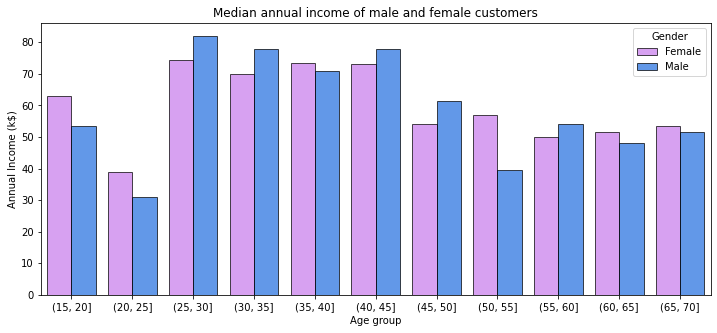

In [42]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

For Females the age groups of 35-45 earn the most and Female 35-40 age group overshadows the earnings of male. 

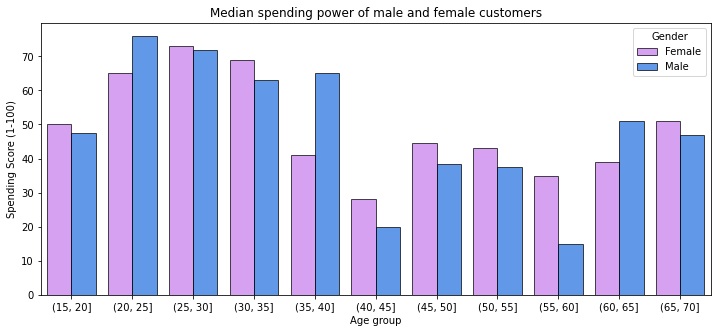

In [43]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Spending Score (1-100)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median spending power of male and female customers')
ax.set_xlabel('Age group')
plt.show()

Age group of male from 20-25 has the highest spending power and age group of females from 25-30 has the highest spending power

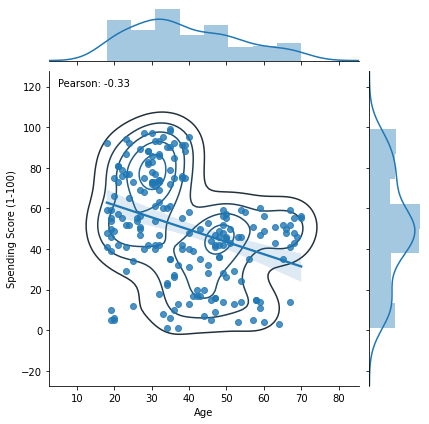

In [58]:
#Correlation
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr, _ = pearsonr(data['Age'], data['Spending Score (1-100)'])

jp = (sns.jointplot('Age', 'Spending Score (1-100)', data=data,
                     kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(5,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

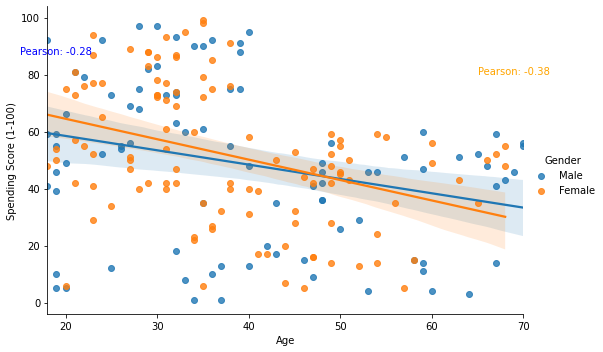

In [60]:
# calculating Pearson's correlation betweem ,age groups and spending power
corr1, _ = pearsonr(males_age.values, male_spendings.values)
corr2, _ = pearsonr(females_age.values, female_spendings.values)

sns.lmplot('Age', 'Spending Score (1-100)' , data=data, hue='Gender',
          aspect=1.5)

plt.text(15,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

We see very low negetive correlation between age and spending score (1-00). We can similarly find out how are other factors related to each other. 

# Clustering 

### Kmeans

The most well-known partitional clustering algorithm is K-Means. 
There are 3 main steps in K-Means algorithm (known also as Lloyd’s algorithm):

1. Split samples into initial groups by using seed points. The nearest samples to these seed point will create initial clusters.
2. Calculate samples distances to groups’ central points (centroids) and assign the nearest samples to their cluster.
3. The third step is to calculate newly created (updated) cluster centroids.

Then repeat steps 2 and 3 until the algorithm converges.

This is known as NP-hard problem, meaning this is a greedy algorithm and converges to the local minimum. The computational cost of Lloyd’s K-Means algorithm is O(kn), where k is a number of clusters and n is a number of samples. This is not bad when compared with other clustering algorithms. Despite converging usually to a local minimum, K-means is relatively fast and when groups are well isolated from each other it is likely that it converges to the global minimum. Because the result of clusterisation depends on the initialisation criteria it is common to run the analysis for various initialisation points and choose the one with minimum resultant inertia. There are some improvements to the algorithm solving problem of the local minima.

In general, a user of the K-Means algorithm is required to define three main parameters:

##### Initialisation criteria
In scikit-learn, a clever initialisation scheme is implemented: “k-means++” proposed by Arthur and Vassilvitskii. It creates initial centroids generally distant from each other increasing probability of obtaining better results. There is also a possibility to use a random point’s generator. There are ongoing efforts to create the most efficient seeding method for K-Means algorithm, one of them is based on Independent Component Analysis.

##### Number of clusters
Selecting a number of clusters is the most challenging part of setting this algorithm. There are no hard mathematical criteria for this and many heuristic/simplified approaches have been developed. One of the simplest and the most popular one is the elbow method shown in this analysis. Additionaly a silhouette score will be used as well. There are also other, often advanced, options for choosing the optimal number of clusters (however, not used in this notebook and not implemented in sklearn).

##### A distance metric (not required in scikit learn implementation)
There are various options to calculate the distance between points. The most popular one is simply the Euclidean metric and it is the one implemented in scikit-learn. It is often called spherical k-means model. It has a drawback that it finds spherical-like groups only and tends to become inflated in highly multi-dimensional analyses (“curse of dimensionality”). 

There are numerous ongoing researches and variations proposed to K-Means, e.g.:

K-Medoid where the centroid is defined as the most centrally located object)
K-Median where the centroid is calculated using median instead of a mean,
Fuzzy C-means model

##### Some take-aways about K-Means:

* Euclidean distances are used
* Number of clusters has to be defined for the algorithm
* Centroid is calculated using mean distance to cluster members
* Clusters are assumed isotropic and convex
* Stochastic algorithm – results depend on the initialisation criteria
* Creates groups of equal variance (minimises inertia)
* Prone to the “curse of dimensionality”
* Can be run in parallel – so it scales well

### Perfoming segmentation using 2 variables

#### Age and spending Score

In [209]:
X1 = data[['Age' , 'Spending Score (1-100)']].iloc[: , :].values
inertia = []
s_scores = []
for n in range(2 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)
    silhouette_avg = silhouette_score(X1, algorithm.labels_)
    s_scores.append(silhouette_avg) # data for the silhouette score method

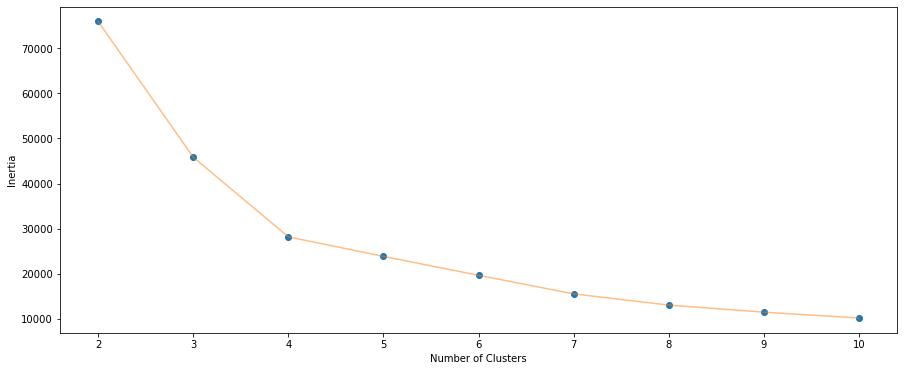

In [211]:
#The Elbow Chart
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(2 , 11) , inertia , 'o')
plt.plot(np.arange(2 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

Now we are unclear which clusters to go for 4 or 5 or 6. Here we use <b>The Silhouette Method</b>. The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. If many points have a negative Silhouette value, it may indicate that we have created too many or too few clusters.

I mentioned before that a high Silhouette Score is desirable. The Silhouette Score reaches its global maximum at the optimal k. This should ideally appear as a peak in the Silhouette Value-versus-k plot.

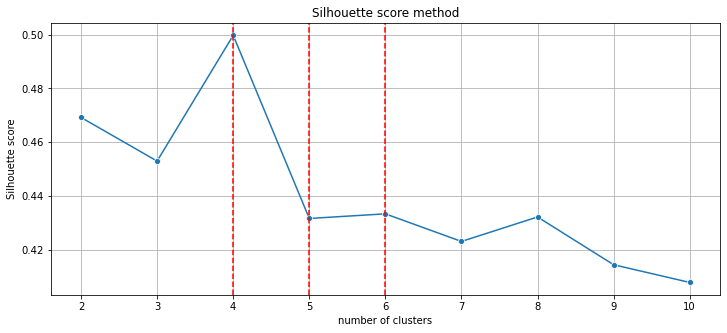

In [213]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(np.arange(2 , 11), s_scores, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(4, ls="--", c="red")
ax.axvline(5, ls="--", c="red")
ax.axvline(6, ls="--", c="red")
plt.grid()
plt.show()

We see that silhoutte score is maximum at k=4. So we go ahead and take that value

The Elbow Method is more of a decision rule, while the Silhouette is a metric used for validation while clustering. Thus, it can be used in combination with the Elbow Method.

In [214]:
algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [215]:
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

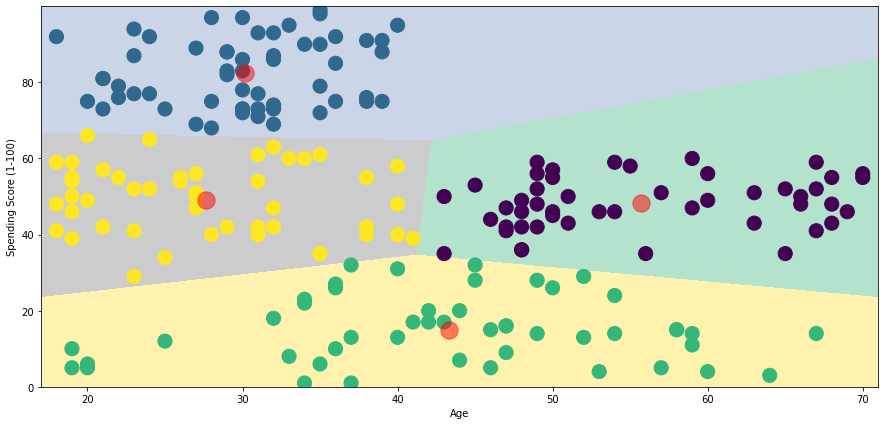

In [216]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Age' ,y = 'Spending Score (1-100)' , data = data , c = labels1 , 
            s = 200 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Age')
plt.show()

Similarly we can go for the combinations of other variables

### Perfoming segmentation using all the numeric variables

In [79]:
X = data[['Age' ,'Annual Income (k$)' ,'Spending Score (1-100)']]
inertia = []
s_scores = []
for n in range(2 , 11):
    algorithm = KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan').fit(X) 
    inertia.append(algorithm.inertia_)
    silhouette_avg = silhouette_score(X, algorithm.labels_)
    s_scores.append(silhouette_avg) # data for the silhouette score method

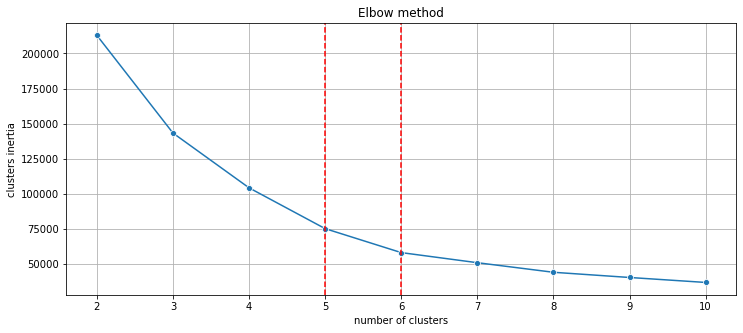

In [81]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(np.arange(2 , 11), inertia, marker='o', ax=ax)
ax.set_title("Elbow method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("clusters inertia")
ax.axvline(5, ls="--", c="red")
ax.axvline(6, ls="--", c="red")
plt.grid()
plt.show()

A choice of 5 or 6 clusters seems to be fair. Let's see the silhouette score.

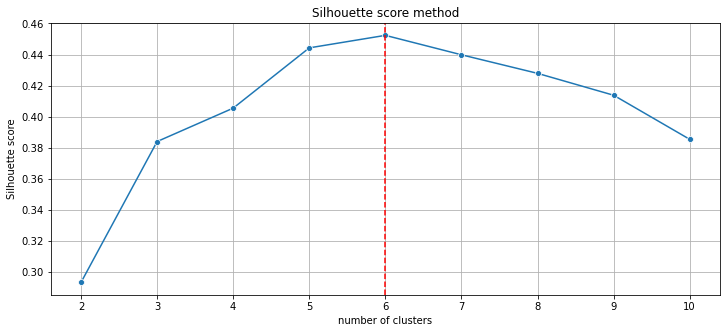

In [82]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(np.arange(2 , 11), s_scores, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(6, ls="--", c="red")
plt.grid()
plt.show()

Silhouette score method indicates the best options would be respectively 6 or 5 clusters. Let's compare both.

In [91]:
#For clusters of K=6
KM6 = (KMeans(n_clusters = 6 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
KM6.fit(X)
labels6 = KM6.labels_
centroids6 = KM6.cluster_centers_
KM6_df = data.copy()
KM6_df['labels'] = labels6

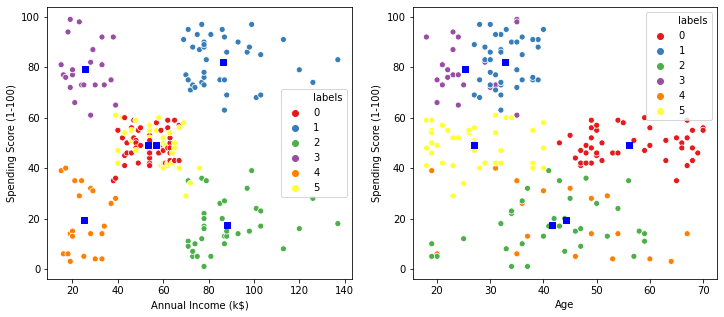

In [94]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM6_df,
                hue='labels', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM6_df,
                hue='labels', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(centroids6[:,1],centroids6[:,2], marker='s', s=40, c="blue")
axes[1].scatter(centroids6[:,0],centroids6[:,2], marker='s', s=40, c="blue")
plt.show()

K-Means algorithm generated the following 6 clusters:

* younger clients with **medium** annual and **medium** spending score
* clients with **high** annual income and **low** spending score
* younger clients with **medium** annual and **medium** spending score
* clients with **high** annual income and **high** spending score
* clients with **low** annual income and **low** spending score
* clients with **low** annual income and **high** spending score

There are no distinct groups is terms of customers age.

In [100]:
KM_clust_sizes = KM6_df.groupby('labels').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
labels,
0,45
1,39
2,35
3,22
4,21
5,38


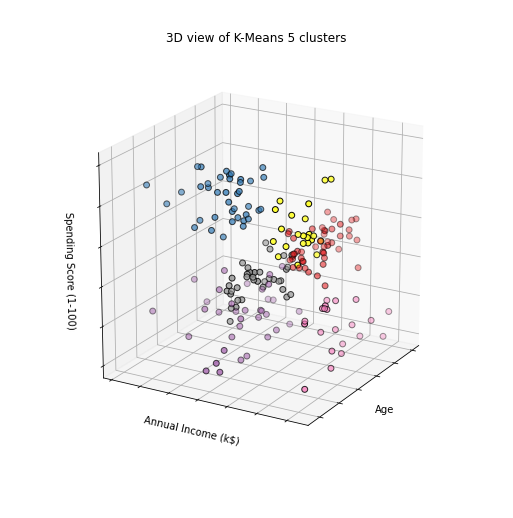

In [104]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM6_df['Age'],
           KM6_df['Annual Income (k$)'],
           KM6_df['Spending Score (1-100)'],
           c=KM6_df['labels'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

In [207]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['labels']==n]['Age'],
        y = db[db['labels']==n]['Spending Score (1-100)'],
        z = db[db['labels']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            color = KM6_df['labels'],
            size = 5,
            line=dict(
            color= KM6_df['labels'],
            width= 12
        ),
        opacity=0.8
        )
     )

trace0 = tracer(KM6_df, 0, 'Cluster 0')
trace1 = tracer(KM6_df, 1, 'Cluster 1')
trace2 = tracer(KM6_df, 2, 'Cluster 2')
trace3 = tracer(KM6_df, 3, 'Cluster 3')
trace4 = tracer(KM6_df, 4, 'Cluster 4')
trace5 = tracer(KM6_df, 5, 'Cluster 5')

trace_data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title = 'Clusters with k=6 wrt Age, Income and Spending Scores',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=trace_data, layout=layout)
py.offline.iplot(fig)


In [110]:
#For clusters of K=5
KM5 = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
KM5.fit(X)
labels5 = KM5.labels_
centroids5 = KM5.cluster_centers_
KM5_df = data.copy()
KM5_df['labels'] = labels5

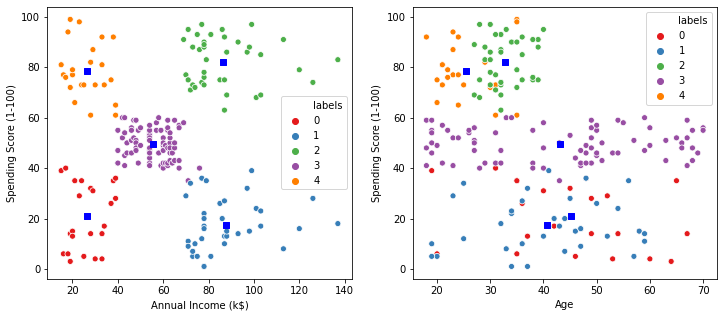

In [111]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM5_df,
                hue='labels', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM5_df,
                hue='labels', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(centroids5[:,1],centroids5[:,2], marker='s', s=40, c="blue")
axes[1].scatter(centroids5[:,0],centroids5[:,2], marker='s', s=40, c="blue")
plt.show()

K-Means algorithm generated the following 5 clusters:

* clients with **low** annual income and **high** spending score
* clients with **medium** annual income and **medium** spending score
* clients with **high** annual income and **low** spending score
* clients with **high** annual income and **high** spending score
* clients with **low** annual income and **low** spending score

There are no distinct groups is terms of customers age.

In [112]:
KM_clust_sizes5 = KM5_df.groupby('labels').size().to_frame()
KM_clust_sizes5.columns = ["KM_size"]
KM_clust_sizes5

,KM_size
labels,
0,23
1,36
2,39
3,79
4,23


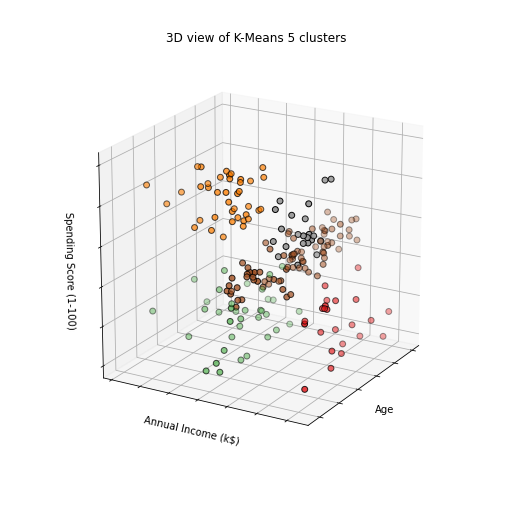

In [113]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM5_df['Age'],
           KM5_df['Annual Income (k$)'],
           KM5_df['Spending Score (1-100)'],
           c=KM5_df['labels'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

In [118]:
trace0 = tracer(KM5_df, 0, 'Cluster 0')
trace1 = tracer(KM5_df, 1, 'Cluster 1')
trace2 = tracer(KM5_df, 2, 'Cluster 2')
trace3 = tracer(KM5_df, 3, 'Cluster 3')
trace4 = tracer(KM5_df, 4, 'Cluster 4')

trace_data5 = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters wrt Age, Income and Spending Scores and k = 5',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=trace_data5, layout=layout)
py.offline.iplot(fig)


#### Hierarchial Clustering

Hierarchical clustering, also known as hierarchical cluster analysis, is an algorithm that groups similar objects into groups called clusters. The endpoint is a set of clusters, where each cluster is distinct from each other cluster, and the objects within each cluster are broadly similar to each other. This hierarchy of clusters is represented as a tree (or dendrogram).

The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together

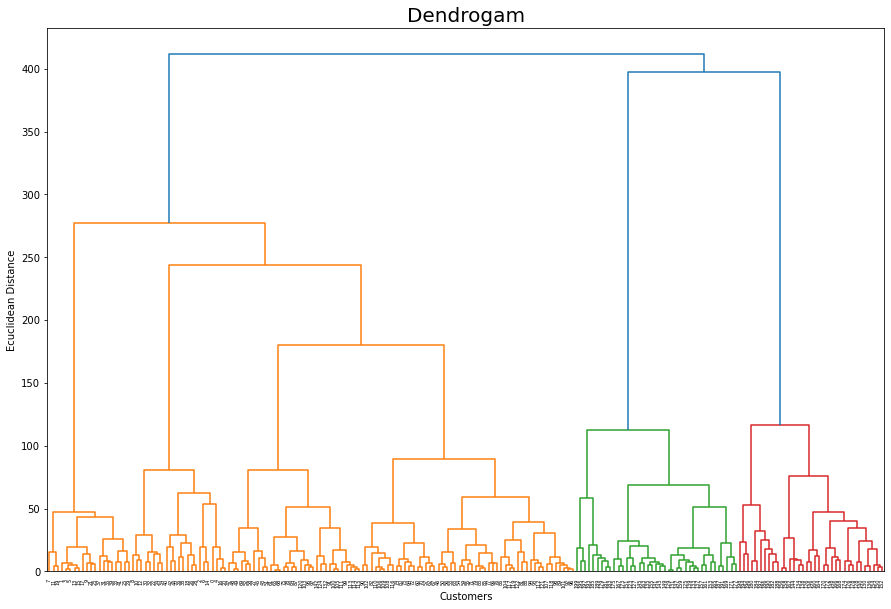

In [221]:
#Using Dendrograms to find out optimal clusters

dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogam', fontsize = 20)
plt.xlabel('Customers')
plt.ylabel('Ecuclidean Distance')
plt.show()

In [226]:
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
hc.fit(X)
labels_hc = hc.labels_
hc_df = data.copy()
hc_df['labels'] = labels_hc

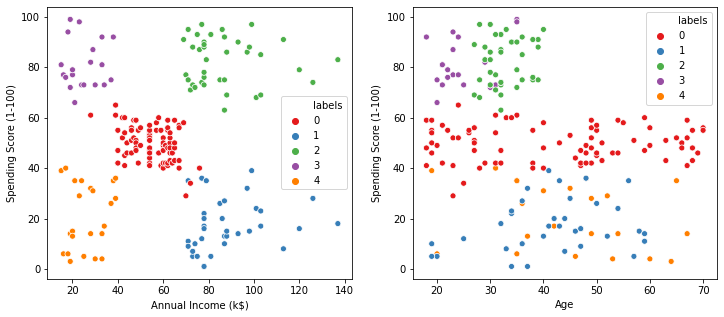

In [234]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))
sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=hc_df,
                hue='labels', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=hc_df,
                hue='labels', palette='Set1', ax=axes[1], legend='full')

plt.show()

Almost the same type of clusters for Spending Score and Annual Income but no definite clusters for Age group 

#### DBSCAN

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. 

A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). There are two parameters to the algorithm, <b>min_samples</b> and <b>eps</b>, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster.

A “dense region” is therefore created by a minimum number of points within distance between all of them, Eps. Points which are within this distance but not close to minimum number of other points are treated as “border points”. Remaining ones are noise or outliers. 

##### Advantages of this approach:

it finds number of clusters itself, based on eps and MinPts parameters
It it able to differentiate elongated clusters or clusters surrounded by other clusters in contrary to e.g. K-Means where clusters are always convex.
It is also able to find points not fitting into any cluster – it detects outliers.

##### The biggest drawback of DBSCAN:

High computational expense of average O(n log(n)) coming from a need to execute a neighbourhood query for each point.
Poorly identifies clusters with various densities

In [121]:
eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated
DBSCAN_params = list(product(eps_values, min_samples))# creates a mxn combinations of eps and min values

In [123]:
no_of_clusters = []
sil_score = []
for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X, DBS_clustering.labels_))

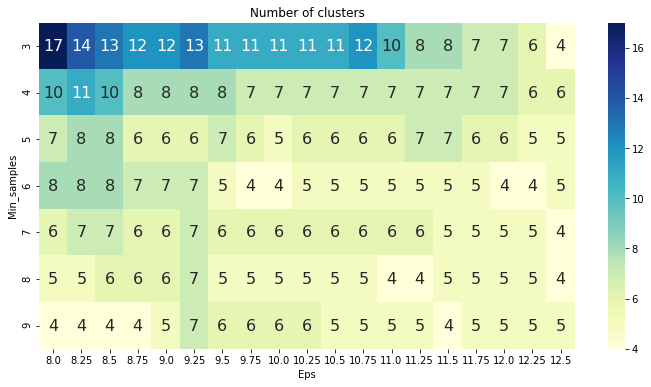

In [124]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

Range of clusters is between 17 to 4. Now we see which cluster has the maximum value from the heat map and choose the corresponding min and eps values

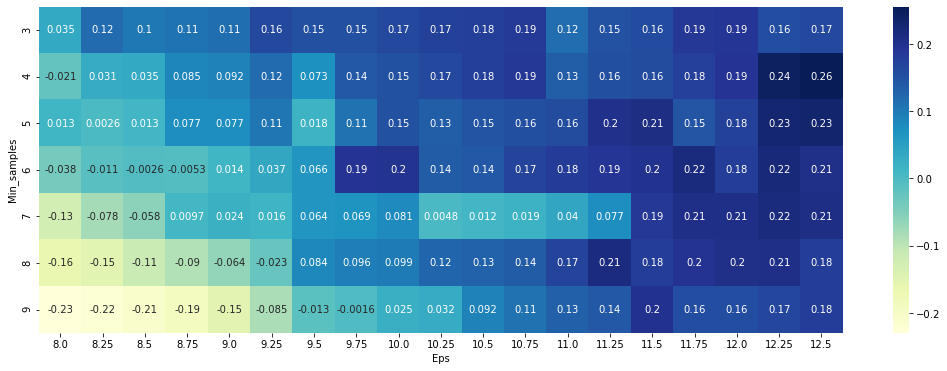

In [127]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

The highest value of 0.26 is for 12.5 and 4

In [129]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X)

DBSCAN_clustered = X.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

In [130]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


We have
<li> Outliers = 18 denoted by cluster -1
<li> Core clusters = 0-4 where 0 has around 112 data points

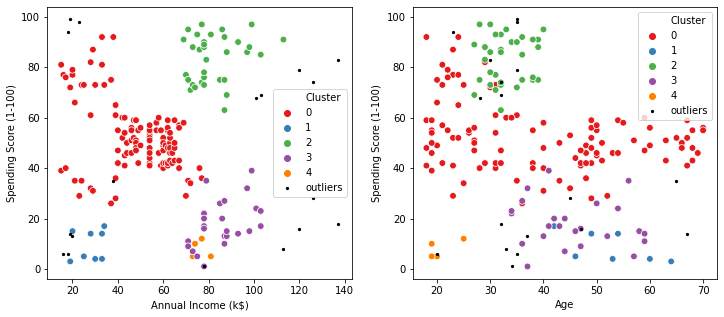

In [131]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot('Age', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()
plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()


The graph above shows that there are some outliers - these points do not meet distance and minimum samples requirements to be recognised as a cluster.

#### Affinity Propagation

Do you remember high school, where groups of people formed – and you could only become a member of a particular group if the group’s leaders thought you were cool?


Affinity Propagation is a clustering algorithm proposed for the first time by Brendan Frey and Delbert Dueck in 2007 ("Clustering by Passing Messages Between Data Points") is somewhat based on this. It is built around the concept of sending messages between a pair of points until it converges. These messages are a way of measuring how similar these two points are to each other and can they be exemplars of each other. In plain english, for a set of data points, a “group formation” process begins, where each sample competes with other ones in order to gain group membership. The ones with most group capital, the group leaders are called exemplars 


The algorithm finds an optimum number of clusters itself. This also implies very high time complexity cost of the order O(n²T) where n is the number of samples and T is the number of iterations until convergence. However, a big advantage of AP is the lack of sensitivity to the initialisation criteria.

The user is required to specify two parameters:

* Preference which is a negative number and controls how many exemplars are used
* Damping factor which prevents numerical oscillations when updating messages

Important points

* Contrary to K-means clustering, where convergence is determined with some threshold value, with Affinity Propagation you configure a number of iterations to complete
* During each iteration, each sample broadcasts two types of messages to the other samples
   * The first is called the responsibility r(i,k) – which is the “evidence that sample k should be the exemplar for sample i”.I always remember it as follows: the greater the expected group leadership of k, the greater the responsibility for the group.
   * The other type of message that is sent is the availability. This is the opposite of the responsibility: how certain i is that it should choose k as the exemplar, i.e. how available it is to join a particular group
  
  In the high school case, say that you want to join a semi-cool group (some availability), while you’re more willing to join the really cool group, your availability is much higher for the really cool one. The responsibility tells you something about whose acceptance you need to join the group, i.e. the most likely group leader i.e. exemplar.

In [245]:
no_of_clusters = []
preferences = range(-20000,-500,200)
af_sil_score = [] # silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X, AF.labels_))
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head()

,preference,clusters,sil_score
41,-11800.0,6.0,0.451649
14,-17200.0,6.0,0.451440
55,-9000.0,6.0,0.451440
26,-14800.0,6.0,0.451440
32,-13600.0,6.0,0.451440


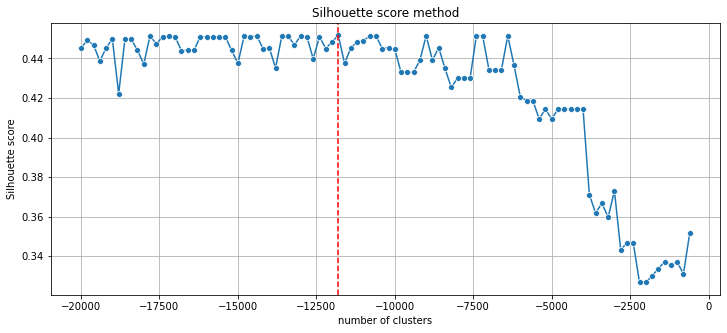

In [246]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(preferences, af_sil_score, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [248]:
AF = AffinityPropagation(preference=-11800).fit(X)

In [250]:
AF_clustered = X.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [251]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


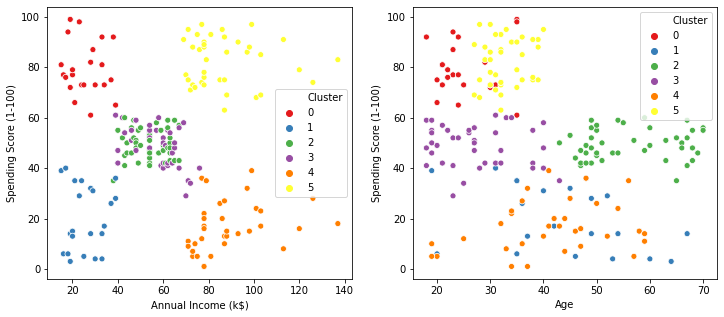

In [252]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

In [254]:
clusters = pd.concat([KM_clust_sizes,KM_clust_sizes5, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,KM_size,DBSCAN_size,AF_size
-1,NaN,NaN,18.0,NaN
0,45.0,23.0,112.0,22.0
1,39.0,36.0,8.0,22.0
2,35.0,39.0,34.0,44.0
3,22.0,79.0,24.0,39.0
4,21.0,23.0,4.0,34.0
5,38.0,NaN,NaN,39.0


From the above comparisons, it is clear that DBSCAN failed to generate reasonable clusters. It is due to its problems in recognising clusters of various densities (which are present in this case).

In turn, K-Means and Affinity Propagation algorithms created reasonable 6 clusters.